In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import matplotlib.pyplot as plt
import methods
import numpy as np
import matplotlib.cm as cm

from scipy.optimize import minimize


In [3]:
# Define the problem (i.e. define the edges of the graph)
# For this demo, we choose a particular 3-regular graph with 4 nodes.
nodes = 4
edges = [(0, 1), (0, 3), (0, 2), (1, 2), (1, 3), (2, 3)]

# Known optimal solution:
optimal_cut = [0, 0, 1, 1]
optimal_size = 4

In [4]:
# Define angles, in the form of list of numbers
# For example, if the number of rounds is 1, betas and gammas could be
betas = [0]
gammas = [0]

num_shots = 5000

## `qaoa_anstaz` object
The main class that includes all the methods is the `qaoa_anstaz` class in the `methods` module.
The cell below initializes it and does a noiseless simulation to obtain the distribution of cut sizes, along with various metrics such as the approximation ratio.

While specifying the ansatz, the actual solution (i.e. the maxcut and maxcut size) can be specified using the arguments `optimal_cut` and `optimal_size`. If not provided by the user, the optimal answer is computed using a brute force method (classically).

In [5]:
ansatz = methods.qaoa_anstaz(nodes, edges, betas, gammas, num_shots = num_shots, optimal_cut = optimal_cut, optimal_size =optimal_size) # Initialize and create circuit
ansatz.execute_circuit() #Simulate the circuit and obtain cutsize distribution and various metrics

In [6]:
ansatz.draw_ansatz()

        ┌───┐                        ┌───────┐                           ░ ┌─┐»
   q_0: ┤ H ├─■───────■───────■──────┤ Rx(0) ├───────────────────────────░─┤M├»
        ├───┤ │ZZ(0)  │       │      └───────┘        ┌───────┐          ░ └╥┘»
   q_1: ┤ H ├─■───────┼───────┼────────■───────■──────┤ Rx(0) ├──────────░──╫─»
        ├───┤         │       │ZZ(0)   │ZZ(0)  │      └───────┘┌───────┐ ░  ║ »
   q_2: ┤ H ├─────────┼───────■────────■───────┼────────■──────┤ Rx(0) ├─░──╫─»
        ├───┤         │ZZ(0)                   │ZZ(0)   │ZZ(0) ├───────┤ ░  ║ »
   q_3: ┤ H ├─────────■────────────────────────■────────■──────┤ Rx(0) ├─░──╫─»
        └───┘                                                  └───────┘ ░  ║ »
meas: 4/════════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«                 
«   q_0: ─────────
«        ┌─┐      
«   q_1: ┤M├──────
«        └╥┘┌─┐   
«   q_2: ─╫─┤M├───
«     

# Plot the graph

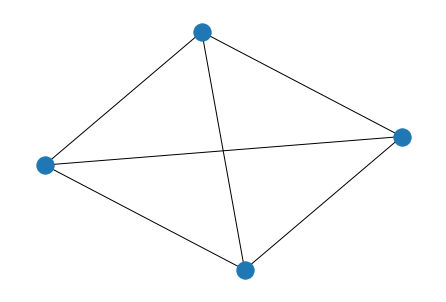

In [7]:
ansatz.draw_graph()

## Cut Size Distribution
The cut size distribution can be plotted using the `qaoa_anstaz.plot_cutsize_dist() ` 
method.

The empirically obtained distribution of cut sizes is stored in variables `qaoa_anstaz.dist_sizes` and `qaoa_anstaz.dist_sizes`.

In [8]:
# Accessing distribution of cut sizes corresponding to the ansatz
actual_maxcut = ansatz.optimal_cut
actual_maxcut_size = ansatz.optimal_size

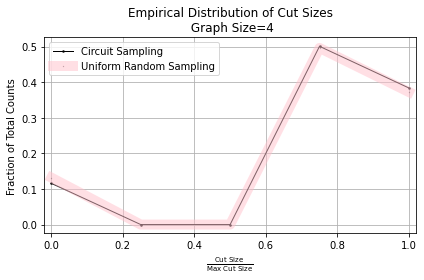

In [9]:
ansatz.plot_cutsize_dist()

## Metrics for quality assessment
Can be accessed from the QAOA_ansatz class after evaluation.
See the cell below for an example.

In [10]:
# Print all the metrics
print("The Approximation Ratio is {:.3f}".format(ansatz.approx_ratio))
print("The Gibbs Ratio is {:.3f}".format(ansatz.gibbs_ratio))
print("The CVaR Ratio is {:.3f}".format(ansatz.cvar_ratio))
print("The Best Cut Ratio is {:.3f}".format(ansatz.bestcut_ratio))

The Approximation Ratio is 0.759
The Gibbs Ratio is 0.824
The CVaR Ratio is 1.000
The Best Cut Ratio is 1.000


## Approximation Ratio Landscape and iterative QAOA
One can compute the approximation ratio over a grid of $\beta$ and $\gamma$ values.
Here, we demonstrate this for rounds=1, but this can easily by generalized to higher number of rounds by choosing a grid over more angles.
Note that $\beta\in [0,\pi)$ while $\gamma\in [0,2\pi)$ for un-weighted MaxCut problem.
(It is straightforward to obtain the landscape for other metrics, such as the CVaR ratio, for example.)

#### Define functions that map $(\beta, \gamma) \rightarrow$ approximation ratio

In [11]:
# Define a function that takes in angles as inputs and output the approximation ratio corresponding to the ansatz circuit at those angles.
def get_approx_ratio_for_angles(nodes, edges, betas, gammas, num_shots):
    """Implement a noiseless simulation to obtain the approximation ratio using qasm_simulator 
    Returns:
        float: approximation ratio from num_shots number of shots
    """
    ansatz = methods.qaoa_anstaz(nodes, edges, betas, gammas, num_shots = num_shots, optimal_cut = optimal_cut, optimal_size =optimal_size)
    ansatz.execute_circuit()
    return ansatz.approx_ratio
angles_to_ar = lambda betas, gammas: get_approx_ratio_for_angles(nodes, edges, betas, gammas, num_shots)

def get_approx_ratio_for_angles_svs(nodes, edges, betas, gammas, num_shots):
    """Implement a noiseless simulation using the STATEVECTOR simulator to obtain the approximation ratio using qasm_simulator 
    Returns:
        float: approximation ratio from num_shots number of shots
    """
    ansatz = methods.qaoa_anstaz(nodes, edges, betas, gammas, num_shots = num_shots, optimal_cut = optimal_cut, optimal_size =optimal_size)
    ansatz.svs_simulate()
    return ansatz.svs_approx_ratio

angles_to_ar_svs = lambda betas, gammas: get_approx_ratio_for_angles_svs(nodes, edges, betas, gammas, num_shots)

#### Loading fixed angle data

In [12]:
# Load the fixed angles from angles_regular_graphs.json taken from https://github.com/danlkv/fixed-angle-QAOA
angle_data = methods.fixed_angles_data['3']['1'] # degree 3, rounds=1
fixed_beta = angle_data['beta']
fixed_gamma = angle_data['gamma']
guarantee = angle_data['AR']
fixed_AR = angles_to_ar(fixed_beta, fixed_gamma)

#### Compute the approximation ratio over a grid of angles

In [13]:
# Compute the approximation ratio landscape using the statevector simulator.
numpts = 50 # Along each axis, i.e. each parameter
_betas = np.linspace(0, np.pi, numpts)
_gammas = np.linspace(0, 2 * np.pi, numpts)
betas_arr, gammas_arr = np.meshgrid(_betas, _gammas)
ar_arr = np.zeros(betas_arr.shape)
for indx in range(numpts):
    for indy in range(numpts):
        betas = [betas_arr[indx, indy]]
        gammas = [gammas_arr[indx, indy]]
        ar_arr[indx, indy] = angles_to_ar_svs(betas, gammas)
        
# Also find the angles on the grid at which the highest approximation ratio was found
# Plot the best obtained approximation ratio point
maxx, maxy = np.unravel_index(np.argmax(ar_arr), ar_arr.shape)

#### Plot the approximation ratio landscape

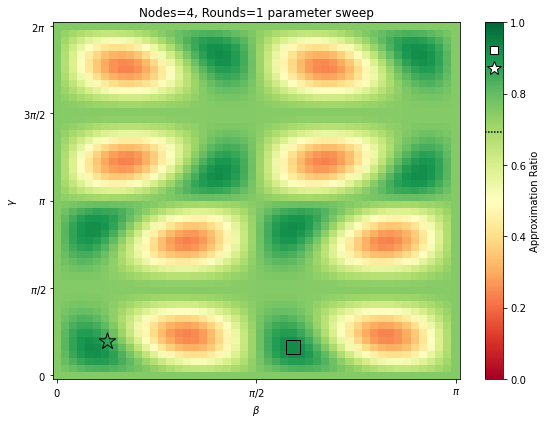

In [14]:
cmap = cm.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(8,6))
# Colormap from the parameter sweep
cc = ax.pcolor(betas_arr, gammas_arr, ar_arr, vmin = 0, vmax = 1, cmap=cmap)
# Plot the AR obtained for the fixed angle parameters
ax.scatter(fixed_beta, fixed_gamma, c= [cmap(fixed_AR)], s=300, marker = '*', linewidths=1, edgecolors='k', label = "Fixed Angle")
# Plot the best obtained approximation ratio point
maxx, maxy = np.unravel_index(np.argmax(ar_arr), ar_arr.shape)
ax.scatter(betas_arr[maxx,maxy], gammas_arr[maxx,maxy], c= [cmap(ar_arr[maxx,maxy])], s=200, marker = 's', linewidths=1, edgecolors='k', label = "Best AR")


# Colorbar
# Mark the AR's obtained at the fixed angles, the highest obtained AR, and the guarantee on the colorbar
cbar = plt.colorbar(cc); cbar.set_label("Approximation Ratio")
cbar.ax.plot(0.5, fixed_AR, 'w*', mec='k', ms=15); cbar.ax.plot(0.5, ar_arr[maxx,maxy] , c='w', marker='s', mec='k', ms=8); cbar.ax.plot([0,1], [guarantee,guarantee] , c='k', ls=(0,(1,1)), mec='k')

ax.set_title("Nodes={}, Rounds=1 parameter sweep".format(nodes))
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
_ = ax.set_xticks([0, np.pi/2, np.pi], labels=["$0$", r"$\pi/2$", r'$\pi$'])
_ = ax.set_yticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi *2], labels=["$0$", r"$\pi/2$", r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    
plt.tight_layout()
plt.savefig("Sweep-Size={}-Rounds={}.png".format(nodes, 1), dpi=300)

#### An aside: "Best Measurement Landscape" 
The best measurement ratio landscape is featureless. All, or almost all grid points have a ratio of 1. It is clear that it is not useful to use this metric to measure quality of the angles. 

In [15]:
# Define a function that takes in angles as inputs and output the best cut ratio corresponding to the ansatz circuit at those angles.
def get_best_measurement_ratio_for_angles(nodes, edges, betas, gammas, num_shots):
    """Implement a noiseless simulation to obtain the approximation ratio using qasm_simulator with num_shots shots
    Returns:
        float: approximation ratio from num_shots number of shots
    """
    ansatz = methods.qaoa_anstaz(nodes, edges, betas, gammas, num_shots = num_shots, optimal_cut = optimal_cut, optimal_size =optimal_size)
    ansatz.execute_circuit()
    return ansatz.bestcut_ratio
angles_to_bcr = lambda betas, gammas: get_best_measurement_ratio_for_angles(nodes, edges, betas, gammas, num_shots)

# Compute the approximation ratio landscape using the statevector simulator.
numpts = 50 # Along each axis, i.e. each parameter
_betas = np.linspace(0, np.pi, numpts)
_gammas = np.linspace(0, 2 * np.pi, numpts)
betas_arr, gammas_arr = np.meshgrid(_betas, _gammas)
bcr_arr = np.zeros(betas_arr.shape)
for indx in range(numpts):
    for indy in range(numpts):
        betas = [betas_arr[indx, indy]]
        gammas = [gammas_arr[indx, indy]]
        bcr_arr[indx, indy] = angles_to_bcr(betas, gammas)

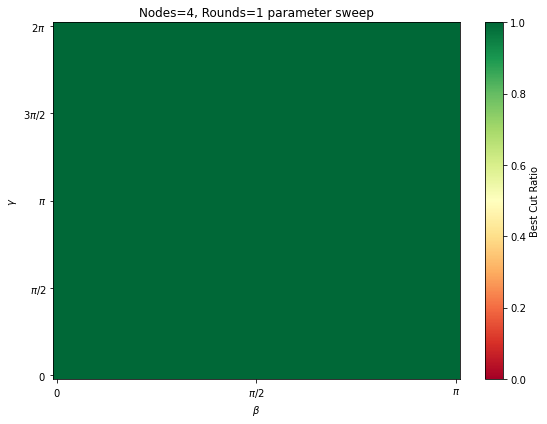

In [16]:
cmap = cm.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(8,6))
# Colormap from the parameter sweep
cc = ax.pcolor(betas_arr, gammas_arr, bcr_arr, cmap=cmap, vmin = 0, vmax = 1)

# Colorbar
cbar = plt.colorbar(cc); cbar.set_label("Best Cut Ratio")

ax.set_title("Nodes={}, Rounds=1 parameter sweep".format(nodes))
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
_ = ax.set_xticks([0, np.pi/2, np.pi], labels=["$0$", r"$\pi/2$", r'$\pi$'])
_ = ax.set_yticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi *2], labels=["$0$", r"$\pi/2$", r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    
plt.tight_layout()
plt.savefig("Sweep-Size={}-Rounds={}_bestcutratio.png".format(nodes, 1), dpi=300)